## Ridge model median cost/watt as function of two features: time (days), size_group

See if regularization stablizes

### Summary of results

$R^2$ values for these models are good.  Again, we see that higher degree polynomials don't extrapolate well (highly unstable) when we go outside the time range of the dataset even thoug they can generalize well in cross-validation and  the test set.

Lower degree polynomials don't fit the data as well, but are far more stable.

###  transform the data and plot

Compute the median of cost/watt, grouped by time, size_group and visualize.

In [1]:
import datetime

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 8))
np.set_printoptions(precision=4, suppress=False)
# please show all columns
pd.set_option("display.max_columns", 60)
import seaborn as sns
sns.set()

In [3]:
# Import sklearn stuff

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline

In [4]:
# lodd up
dfMod = pd.read_csv('../local/data/LBNL_openpv_tts_data/model_data_2.csv',
                    encoding='iso-8859-1', # avoids windows encoding issue
                    index_col='row_id',
                    parse_dates=['install_date'])

In [5]:
dfMod.head()

,num_days,num_weeks,num_months,size_kw,scaleSize,state,cost_per_watt,install_date
row_id,,,,,,,,
1,0.0,0.0,0.0,2.2824,0.0,CA,10.734315,1998-01-09
2,21.0,3.0,0.0,1.8504,0.0,CA,11.108701,1998-01-30
4,26.0,4.0,1.0,2.3076,0.0,CA,8.667013,1998-02-04
6,84.0,12.0,3.0,2.3316,0.0,CA,13.270286,1998-04-03
7,111.0,16.0,3.0,0.9300,0.0,CA,14.654839,1998-04-30


### Group by number of days and scaleSize

In [6]:
by_days_size = dfMod.groupby(['num_days', 'scaleSize'])
med_days_size = by_days_size.cost_per_watt.median()
mean_days_size = by_days_size.cost_per_watt.mean()
print(med_days_size.head())
print()
print(mean_days_size.head())
print

### unstack it see what it looks like; this is good for plotting
df_med_by_days_size = med_days_size.unstack('scaleSize'); df_med_by_days_size.head()

num_days  scaleSize
0.0       0.0          10.734315
21.0      0.0          11.108701
26.0      0.0           8.667013
84.0      0.0          13.270286
111.0     0.0          14.654839
Name: cost_per_watt, dtype: float64

num_days  scaleSize
0.0       0.0          10.734315
21.0      0.0          11.108701
26.0      0.0           8.667013
84.0      0.0          13.270286
111.0     0.0          14.654839
Name: cost_per_watt, dtype: float64


scaleSize,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
num_days,,,,,,,,,,
0.0,10.734315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21.0,11.108701,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26.0,8.667013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84.0,13.270286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
111.0,14.654839,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Plot daily median
Doesn't reject enough noise because of small samples though it's much less noisy than un-aggregated data (except the earliest installations).

In [7]:
df_med_by_days_size.columns

Float64Index([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0], dtype='float64', name='scaleSize')

In [8]:
by_month_size = dfMod.groupby(['num_months', 'scaleSize'])
med_by_month_size = by_month_size.cost_per_watt.median()
mean_by_month_size = by_month_size.cost_per_watt.mean()
print(med_by_month_size.head())
print()
print(mean_by_month_size.head())
print

### unstack it see what it looks like; yes, that's what we need for plotting
### orginal for is almost right for sklearn...
med_by_monthXsize = med_by_month_size.unstack('scaleSize'); med_by_monthXsize.head()

num_months  scaleSize
0.0         0.0          10.921508
1.0         0.0           8.667013
3.0         0.0          13.962563
6.0         1.0           6.858942
7.0         0.0           6.768190
Name: cost_per_watt, dtype: float64

num_months  scaleSize
0.0         0.0          10.921508
1.0         0.0           8.667013
3.0         0.0          13.962563
6.0         1.0           6.858942
7.0         0.0           6.768190
Name: cost_per_watt, dtype: float64


scaleSize,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
num_months,,,,,,,,,,
0.0,10.921508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1.0,8.667013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3.0,13.962563,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6.0,NaN,6.858942,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7.0,6.768190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### End group/aggregate/visualize

---
__============================================__

---


### Model monthly median

This will have the biggest noise rejection because on average the median groups will be larger.  But, it will also have the least data to work with.

In [9]:
### the Xs are in the index; the ys are vals
med_by_month_size.head()

num_months  scaleSize
0.0         0.0          10.921508
1.0         0.0           8.667013
3.0         0.0          13.962563
6.0         1.0           6.858942
7.0         0.0           6.768190
Name: cost_per_watt, dtype: float64

In [10]:
### shove over so I can grab the pieces as columns
df_med_month_size = med_by_month_size.reset_index(); df_med_month_size.head()

,num_months,scaleSize,cost_per_watt
0,0.0,0.0,10.921508
1,1.0,0.0,8.667013
2,3.0,0.0,13.962563
3,6.0,1.0,6.858942
4,7.0,0.0,6.768190


In [11]:
X = df_med_month_size[['num_months', 'scaleSize']].values
y = df_med_month_size[['cost_per_watt']].values
X.shape, y.shape

((1778, 2), (1778, 1))

In [12]:
# Setup the pipeline steps
steps = [('scaler', StandardScaler()),
         ('poly', PolynomialFeatures()),
         ('ridge', Ridge())]

# Create the pipeline: pipeline 
pipeline = Pipeline(steps)

In [13]:
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'scaler', 'poly', 'ridge', 'scaler__copy', 'scaler__with_mean', 'scaler__with_std', 'poly__degree', 'poly__include_bias', 'poly__interaction_only', 'ridge__alpha', 'ridge__copy_X', 'ridge__fit_intercept', 'ridge__max_iter', 'ridge__normalize', 'ridge__random_state', 'ridge__solver', 'ridge__tol'])

In [14]:
# want to plot both R2 and RMSE
def RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# # Create the hyperparameter grid, just poly degree
# poly_space = np.arange(8, 9)
# param_grid = {'poly__degree': poly_space}

poly_space = np.array([8])
alpha_space = np.array([0.001, 0.01, 0.1, 1.0, 10.0, 100.0])
# alpha_space = np.array([.0317])
# Create the hyperparameter grid
param_grid = {'poly__degree': poly_space,
              'ridge__alpha': alpha_space}            


# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=21)

# build the scoring map
scoring = {'Rsquared': 'r2',
           'RMSE': make_scorer(RMSE, greater_is_better=False) }

# Create the GridSearchCV object: gs_cv
gs_cv = GridSearchCV(pipeline, param_grid, cv=3, scoring=scoring, 
                     return_train_score=True, refit='Rsquared',
                     verbose=3)

# Fit to the training set
gs_cv.fit(X_train, y_train)

# Compute and print the metrics
rmse_test = np.sqrt(mean_squared_error(y_test, gs_cv.predict(X_test)))
print("Root Mean Squared Error (test): {}".format(rmse_test))
theR2 = gs_cv.score(X_test, y_test)
print("Best parameters: {}".format(gs_cv.best_params_))
print("test R squared: {}".format(theR2))

# uncomment to see results ds
# gs_cv.cv_results_

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] poly__degree=8, ridge__alpha=0.001 ..............................
[CV]  poly__degree=8, ridge__alpha=0.001, Rsquared=0.8215578597902452, RMSE=-0.7597275687001662, total=   0.0s
[CV] poly__degree=8, ridge__alpha=0.001 ..............................
[CV]  poly__degree=8, ridge__alpha=0.001, Rsquared=0.8344820416716979, RMSE=-0.7383456887408221, total=   0.0s
[CV] poly__degree=8, ridge__alpha=0.001 ..............................
[CV]  poly__degree=8, ridge__alpha=0.001, Rsquared=0.8596756913054204, RMSE=-0.6693019464740267, total=   0.0s
[CV] poly__degree=8, ridge__alpha=0.01 ...............................
[CV]  poly__degree=8, ridge__alpha=0.01, Rsquared=0.8215899604140557, RMSE=-0.7596592305101197, total=   0.0s
[CV] poly__degree=8, ridge__alpha=0.01 ...............................
[CV]  poly__degree=8, ridge__alpha=0.01, Rsquared=0.8344946006746209, RMSE=-0.7383176764886683, total=   0.0s
[CV] poly__degree=8, ridge__alph

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    0.1s finished


In [15]:
gs_cv.best_estimator_

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('poly', PolynomialFeatures(degree=8, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

In [16]:
gs_cv.cv_results_['mean_test_RMSE'], gs_cv.cv_results_['mean_test_Rsquared']

(array([-0.7225, -0.7224, -0.7214, -0.7197, -0.7364, -0.8346]),
 array([0.8386, 0.8386, 0.839 , 0.8398, 0.8322, 0.7849]))

Best parameters: {'poly__degree': 8, 'ridge__alpha': 1.0}
Best model on test set R squared: 0.8628478419828155


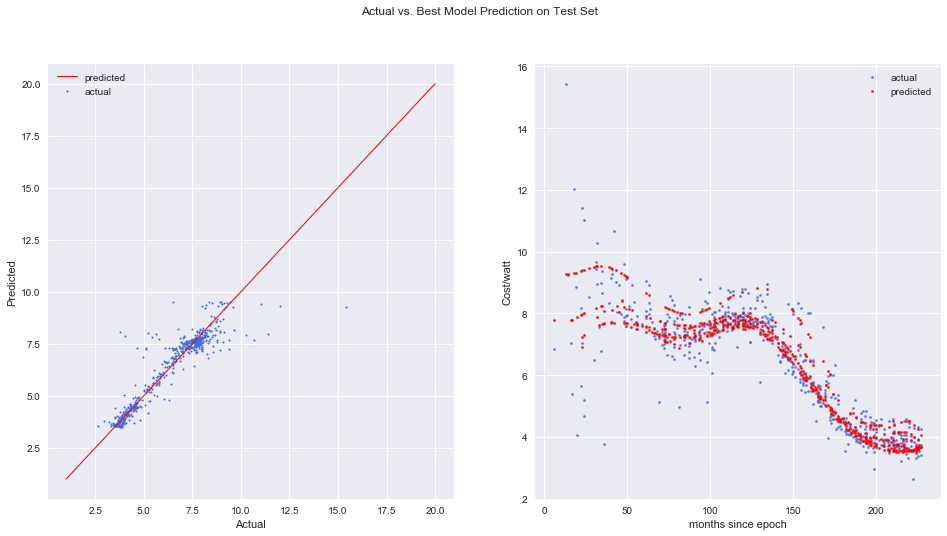

In [17]:
# Show R2
theR2 = gs_cv.score(X_test, y_test)
print("Best parameters: {}".format(gs_cv.best_params_))
print("Best model on test set R squared: {}".format(theR2))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('Actual vs. Best Model Prediction on Test Set')

ax1.scatter(y_test, gs_cv.predict(X_test), marker='.', s=10, color='royalblue', alpha=1, label='actual')
ax1.plot(np.array([1,20]), np.array([1,20]), linewidth=1, color='red', label='predicted')
ax1.set_ylabel('Predicted')
ax1.set_xlabel('Actual')
ax1.legend()

ax2.scatter(X_test[:, 0], y_test, marker='.', color='royalblue', s=20, alpha=0.9, label='actual')
ax2.scatter(X_test[:, 0], gs_cv.predict(X_test), marker='.', color='red', s=20, alpha=1, label='predicted')
ax2.set_ylabel('Cost/watt')
ax2.set_xlabel('months since epoch')
ax2.legend()

plt.show();

### Extrapolate with best model

#### Build an X with scaleSize 5

In [18]:
X[-1, :]

array([227.,   9.])

In [19]:
x1 = np.linspace(0.0, 244, int(244/4)); x1.shape
x2 = np.zeros(61); x2[:] = 5.0
print(x1.shape, x2.shape)

(61,) (61,)


In [20]:
X_future = np.stack([x1, x2], axis=-1); X_future.shape

(61, 2)

In [21]:
gs_cv.predict(X_future).shape

(61, 1)

In [22]:
X_f5 = X_future
X_f1 = X_future.copy()
X_f1[:, 1] = 1.0

In [23]:
X_f9 = X_future.copy()
X_f9[:, 1] = 9.0

In [24]:
X_f3 = X_future.copy()
X_f3[:, 1] = 3.0

In [25]:
X_f7 = X_future.copy()
X_f7[:, 1] = 7.0

In [26]:
X_f4 = X_future.copy()
X_f4[:, 1] = 4.0

In [27]:
X_f6 = X_future.copy()
X_f6[:, 1] = 6.0

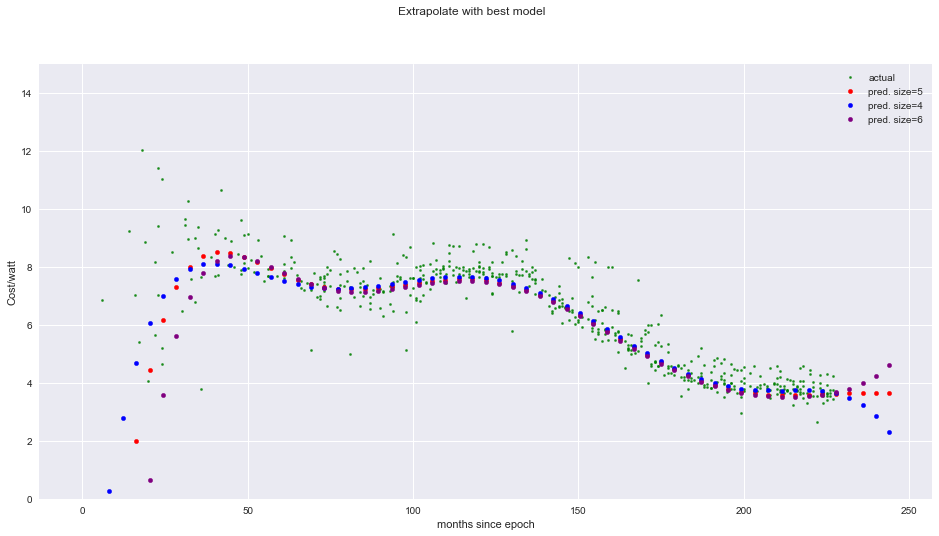

In [28]:
fig, ax = plt.subplots(figsize=(16, 8))
fig.suptitle('Extrapolate with best model')

ax.scatter(X_test[:,0], y_test, marker='.', color='green', s=20, alpha=0.9, label='actual')
ax.scatter(X_f5[:, 0].reshape(-1, 1), gs_cv.predict(X_f5), marker='o', color='red', s=20, alpha=1, label='pred. size=5')
ax.scatter(X_f1[:, 0].reshape(-1, 1), gs_cv.predict(X_f4), marker='o', color='blue', s=20, alpha=1, label='pred. size=4')
ax.scatter(X_f9[:, 0].reshape(-1, 1), gs_cv.predict(X_f6), marker='o', color='purple', s=20, alpha=1, label='pred. size=6')
ax.set_ylabel('Cost/watt')
ax.set_xlabel('months since epoch')
ax.set_ylim(0,15)
ax.legend();

### predict month with 3rd degree model
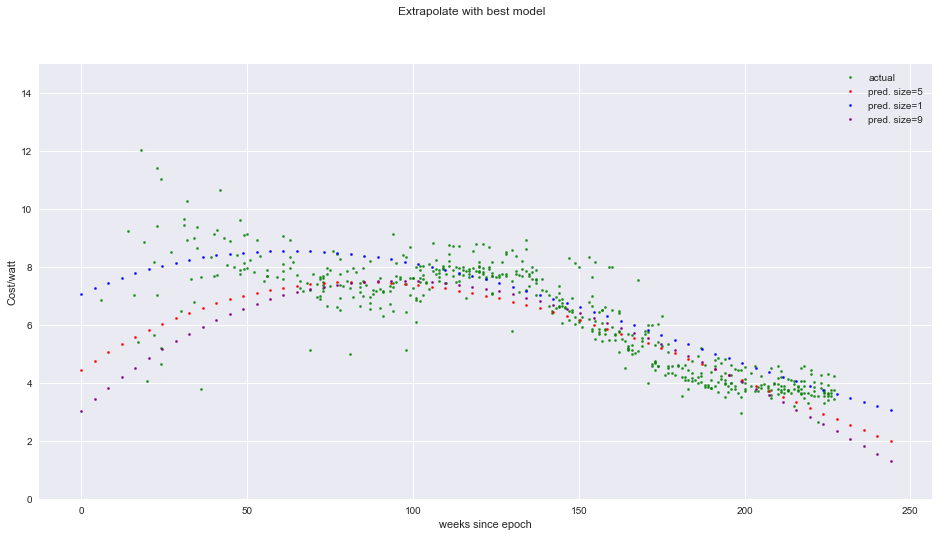

#### Example prediction using 3rd degree model.  

This looks like a fairly good compromise between fit and stability.  $R^2$ with 3rd degree model is around 0.79.  RMSE is about \$0.83.  These are vastly better than strongest direct (non-aggregated) models.  It may be the case that regularizing higher degree polynomials may provide better prediction while better capturing the trends in the data.  

In [29]:
def trainVsTestResults(results): 
    ''' Plot test/train results for R^2 and RMSE'''    

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    sTitle = 'mean cross-validation train/test RMSE and R^2 vs poly degree'
    fig.suptitle(sTitle)
          
    mean_train_RMSE = results['mean_train_RMSE']
    mean_test_RMSE = results['mean_test_RMSE']
    n = len(mean_train_RMSE)
        
    ax1.plot(np.arange(1, n + 1), np.abs(mean_train_RMSE), marker='d', ms=15, alpha=0.5, color='green', label='train');
    ax1.plot(np.arange(1, n + 1), np.abs(mean_test_RMSE), marker='*', ms=10, alpha=1.0, color='red', label='test');
    ax1.set_ylabel('RMSE')
    ax1.set_xlabel('polynomial degree')
    ax1.set_title('mean train/test RMSE vs poly degree')
    ax1.set_ylim(0, 1.5)
    ax1.legend()
    
    mean_train_R2 = results['mean_train_Rsquared']
    mean_test_R2 = results['mean_test_Rsquared']
    n = len(mean_train_R2)
    
    fig.suptitle(sTitle.format(gs_cv.best_params_))

    ax2.plot(np.arange(1, n + 1), np.abs(mean_train_R2), marker='d', ms=15, alpha=0.5, color='green', label='train');
    ax2.plot(np.arange(1, n + 1), np.abs(mean_test_R2), marker='*', ms=10, color='red', label='test');
    ax2.set_ylabel('R^2')
    ax2.set_xlabel('polynomial degree')
    ax2.set_title('mean train/test R2 vs poly degree')
    ax2.set_ylim(0, 1)
    ax2.legend()
          
    r2 = gs_cv.score(X_test, y_test)
    print("Best parameters: {}".format(gs_cv.best_params_))
    print("Best parameters test R squared: {}".format(r2))

Best parameters: {'poly__degree': 8, 'ridge__alpha': 1.0}
Best parameters test R squared: 0.8628478419828155


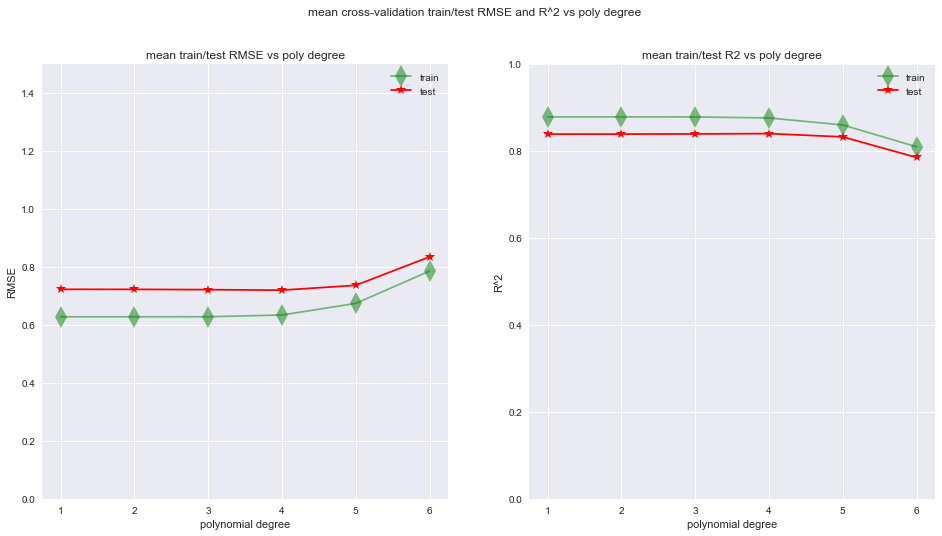

In [30]:
trainVsTestResults(gs_cv.cv_results_)

#### Predictions at degree 8 are unstable.  It seems overfitted but the crossval plot says that it's not.

This is without including the state.  Maybe it's trying to use time and size to model variance caused by state (i.e. misuse).  The state accounts for maybe \$1 and best test RMSE is about \$0.77.  So, hmmm...

Another thing: maybe I don't want to poly expand size; it's a simple relation - slight negative correlation.  Would that help?

The good news: these are very fast to fit; might make sense to drive a search outside of grid_search_cv...

Here's another idea (just in case I run out): what about using size (of the group) to weight the price instead of using as parameter.  I wonder what that would do (have to learn the technique).

While I'm brainstorming, the vendor could matter.

#### 3rd degree model looks okay and predictions look okay, also maybe 6th


### Model weekly median

In [31]:
### the Xs are in the index; the ys are vals
med_by_week_size.head()

NameError: name 'med_by_week_size' is not defined

In [ ]:
### shove over so I can grab the pieces as columns
df_med_week_size = med_by_week_size.reset_index(); df_med_week_size.head()

In [ ]:
X = df_med_week_size[['num_weeks', 'scaleSize']].values
y = df_med_week_size[['cost_per_watt']].values
X.shape, y.shape

In [ ]:
# want to plot both R2 and RMSE
def RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Create the hyperparameter grid, just poly degree
# poly_space = np.arange(1, 18)
# param_grid = {'poly__degree': poly_space}

poly_space = np.array([9])
alpha_space = np.array([ 0.67])
# alpha_space = np.array([.0317])
# Create the hyperparameter grid
param_grid = {'poly__degree': poly_space,
              'ridge__alpha': alpha_space}            


# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=21)

# build the scoring map
scoring = {'Rsquared': 'r2',
           'RMSE': make_scorer(RMSE, greater_is_better=False) }

# Create the GridSearchCV object: gs_cv
gs_cv = GridSearchCV(pipeline, param_grid, cv=3, scoring=scoring, 
                     return_train_score=True, refit='Rsquared')

# Fit to the training set
gs_cv.fit(X_train, y_train)

# Compute and print the metrics
theR2 = gs_cv.score(X_test, y_test)
print("Best parameters: {}".format(gs_cv.best_params_))
print("test R squared: {}".format(theR2))

# uncomment to see results ds
# gs_cv.cv_results_

In [ ]:
gs_cv.cv_results_['mean_test_RMSE'], gs_cv.cv_results_['mean_test_Rsquared']

In [ ]:
# Show R2
theR2 = gs_cv.score(X_test, y_test)
print("Best parameters: {}".format(gs_cv.best_params_))
print("Best R squared: {}".format(theR2))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('Actual vs. Best Model Prediction on Test Set')

ax1.scatter(y_test, gs_cv.predict(X_test), marker='.', s=10, color='royalblue', alpha=1, label='actual')
ax1.plot(np.array([1,20]), np.array([1,20]), linewidth=1, color='red', label='predicted')
ax1.set_ylabel('Predicted')
ax1.set_xlabel('Actual')
ax1.legend()

ax2.scatter(X_test[:, 0], y_test, marker='.', color='royalblue', s=20, alpha=0.9, label='actual')
ax2.scatter(X_test[:, 0], gs_cv.predict(X_test), marker='.', color='red', s=20, alpha=1, label='predicted')
ax2.set_ylabel('Cost/watt')
ax2.set_xlabel('weeks since epoch')
ax2.legend()

plt.show();

In [ ]:
X[-1, :]

In [ ]:
x1 = np.linspace(0.0, 1150, int(1150/13)); x1.shape
x2 = np.zeros(88); x2[:] = 5.0
print(x1.shape, x2.shape)

In [ ]:
X_future = np.stack([x1, x2], axis=-1); X_future.shape

In [ ]:
gs_cv.predict(X_future).shape

In [ ]:
X_f5 = X_future
X_f1 = X_future.copy()
X_f1[:, 1] = 1.0

In [ ]:
X_f9 = X_future.copy()
X_f9[:, 1] = 9.0

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8))
fig.suptitle('Extrapolate with best model')


ax.scatter(X_test[:,0], y_test, marker='.', color='green', s=20, alpha=0.9, label='actual')
ax.scatter(X_f5[:, 0].reshape(-1, 1), gs_cv.predict(X_f5), marker='d', color='red', s=20, alpha=1, label='pred. size=5')
ax.scatter(X_f1[:, 0].reshape(-1, 1), gs_cv.predict(X_f4), marker='D', color='blue', s=20, alpha=1, label='pred. size=4')
ax.scatter(X_f9[:, 0].reshape(-1, 1), gs_cv.predict(X_f6), marker='o', color='purple', s=20, alpha=1, label='pred. size=6')
ax.set_ylabel('Cost/watt')
ax.set_xlabel('weeks since epoch')
ax.set_ylim(0,15)
ax.legend();

#### Great fit, unstable predictions.  Either back off the poly degree or regularize.

---

---
### Median by day
---

In [ ]:
### the Xs are in the index; the ys are vals
med_days_size.head()

In [ ]:
### shove over so I can grab the pieces as columns
df_med_days_size = med_days_size.reset_index(); df_med_days_size.head()

In [ ]:
X = df_med_days_size[['num_days', 'scaleSize']].values
y = df_med_days_size[['cost_per_watt']].values
X.shape, y.shape

In [ ]:
# want to plot both R2 and RMSE
def RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# # Create the hyperparameter grid, just poly degree
# poly_space = np.arange(1, 15)
# param_grid = {'poly__degree': poly_space}
poly_space = np.array([10])
alpha_space = np.array([0.67, 1.0, 3.171])
# alpha_space = np.array([.0317])
# Create the hyperparameter grid
param_grid = {'poly__degree': poly_space,
              'ridge__alpha': alpha_space}            

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=21)

# build the scoring map
scoring = {'Rsquared': 'r2',
           'RMSE': make_scorer(RMSE, greater_is_better=False) }

# Create the GridSearchCV object: gs_cv
gs_cv = GridSearchCV(pipeline, param_grid, cv=3, scoring=scoring, 
                     return_train_score=True, refit='Rsquared')

# Fit to the training set
gs_cv.fit(X_train, y_train)

# Compute and print the metrics
theR2 = gs_cv.score(X_test, y_test)
print("Best parameters: {}".format(gs_cv.best_params_))
print("test R squared: {}".format(theR2))

# uncomment to see results ds
# gs_cv.cv_results_

In [ ]:
gs_cv.cv_results_['mean_test_RMSE'], gs_cv.cv_results_['mean_test_Rsquared']

In [ ]:
# Show test R2
theR2 = gs_cv.score(X_test, y_test)
print("Best parameters: {}".format(gs_cv.best_params_))
print("Best model R squared on test set: {}".format(theR2))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('Actual vs. Best Model Prediction on Test Set')

ax1.scatter(y_test, gs_cv.predict(X_test), marker='.', s=10, color='royalblue', alpha=1, label='actual')
ax1.plot(np.array([1,20]), np.array([1,20]), linewidth=1, color='red', label='predicted')
ax1.set_ylabel('Predicted')
ax1.set_xlabel('Actual')
ax1.legend()

ax2.scatter(X_test[:, 0], y_test, marker='.', color='royalblue', s=20, alpha=0.9, label='actual')
ax2.scatter(X_test[:, 0], gs_cv.predict(X_test), marker='.', color='red', s=20, alpha=1, label='predicted')
ax2.set_ylabel('Cost/watt')
ax2.set_xlabel('weeks since epoch')
ax2.legend()

plt.show();

#### Build an X for prediction

In [ ]:
# last value of days
X[-1, :]

In [ ]:
# 1 1/2 years + last
365 * 1.5 + 7000

In [ ]:
# predict every 13 weeks
x1 = np.linspace(0.0, 7550, int(7550/(13*7))); x1.shape
x2 = np.zeros(82); x2[:] = 5.0
print(x1.shape, x2.shape)

In [ ]:
# glue
X_future = np.stack([x1, x2], axis=-1); X_future.shape

In [ ]:
# check shape
gs_cv.predict(X_future).shape

In [ ]:
# now with scaleSize = 1
X_f5 = X_future
X_f1 = X_future.copy()
X_f1[:, 1] = 1.0

In [ ]:
# now with scaleSize = 9
X_f9 = X_future.copy()
X_f9[:, 1] = 9.0

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8))
fig.suptitle('Extrapolate with best model')


ax.scatter(X_test[:,0], y_test, marker='.', color='green', s=20, alpha=0.7, label='actual')
ax.plot(X_f5[:, 0].reshape(-1, 1), gs_cv.predict(X_f5), marker='.', color='red',  alpha=1, label='pred. size=5')
ax.plot(X_f1[:, 0].reshape(-1, 1), gs_cv.predict(X_f3), marker='.', color='blue',  alpha=1, label='pred. size=3')
ax.plot(X_f9[:, 0].reshape(-1, 1), gs_cv.predict(X_f7), marker='.', color='purple', alpha=1, label='pred. size=7')
ax.set_ylabel('Cost/watt')
ax.set_xlabel('weeks since epoch')
ax.set_ylim(0,15)
ax.legend();

### Same story: this model is too flexible for prediction.  It needs calming down.

---

### prediction using cubic model and day time scale for median

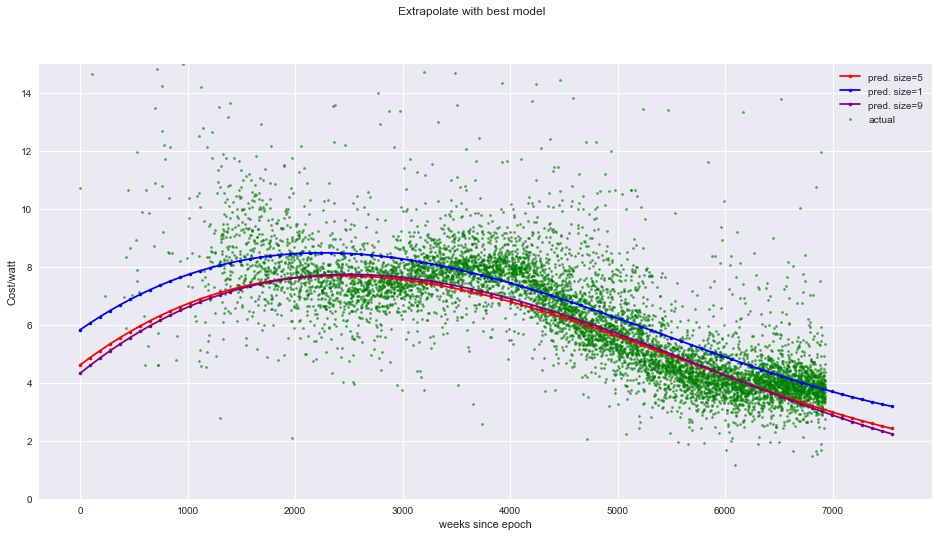

__===============================================================================__

### Okay regularize using poly 10 - if I crank up regularization it should reduce overfitting.  Don't know if that will help predictive properties.